# Analysis of model-model similarity
Which models’ behavior were most similar to which other models’?

**The purpose of this notebook is to:** 
* analyse the similarity of predictions made by different models

**This notebook depends on:**
* Running `./generate_dataframes.py` (INTERNAL USE ONLY)
* Running `./upload_results.py` (INTERNAL USE ONLY)
* Running `./download_results.py` (PUBLIC USE)

## setup

#### Load packages

In [1]:
import os
import sys
import urllib, io

sys.path.append('./analysis_helpers')
from importlib import reload

import numpy as np
import scipy.stats as stats
import pandas as pd

import analysis_helpers as h

import pymongo as pm
from collections import Counter
import json
import re
import ast

from PIL import Image, ImageOps, ImageDraw, ImageFont 

from io import BytesIO
import base64

from tqdm.notebook import tqdm   

import  matplotlib
import seaborn as sns
from matplotlib import pylab, mlab, pyplot
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
plt.style.use('seaborn-white')

import seaborn as sns

%matplotlib inline
import scipy.stats
import sklearn.metrics
import random

from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

#### options

In [2]:
# display all columns
pd.set_option('display.max_columns', None)

# seaborn plotting themes
sns.set_context('talk')
sns.set_style("whitegrid")

#### set up paths and directories

In [3]:
## directory & file hierarchy
proj_dir = os.path.abspath('..')
datavol_dir = os.path.join(proj_dir,'data')
analysis_dir =  os.path.abspath('.')
results_dir = os.path.join(proj_dir,'results')
plot_dir = os.path.join(results_dir,'plots')
csv_dir = os.path.join(results_dir,'csv')
json_dir = os.path.join(results_dir,'json')
exp_dir = os.path.abspath(os.path.join(proj_dir,'behavioral_experiments'))
png_dir = os.path.abspath(os.path.join(datavol_dir,'png'))

## add helpers to python path
if os.path.join(proj_dir,'stimuli') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'stimuli'))
    
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)   
    
if not os.path.exists(csv_dir):
    os.makedirs(csv_dir)       
    
## add helpers to python path
if os.path.join(analysis_dir,'utils') not in sys.path:
    sys.path.append(os.path.join(analysis_dir,'utils'))   

def make_dir_if_not_exists(dir_name):   
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)
    return dir_name

## create directories that don't already exist        
result = [make_dir_if_not_exists(x) for x in [results_dir,plot_dir,csv_dir]]

### load human data

In [4]:
from experiment_meta import *
HEM = pd.DataFrame(NEURIPS2021_EXPS) # HEM = "human experiment metadata"
HEM

,study,bucket_name,stim_version,iterationName
0,dominoes_pilot,human-physics-benchmarking-dominoes-pilot,production_1,production_1_testing
1,collision_pilot,human-physics-benchmarking-collision-pilot,production_2,production_2_testing
2,towers_pilot,human-physics-benchmarking-towers-pilot,production_2,production_2_testing
3,linking_pilot,human-physics-benchmarking-linking-pilot,production_2,production_2_testing
4,containment_pilot,human-physics-benchmarking-containment-pilot,production_2,production_2_testing
5,rollingsliding_pilot,human-physics-benchmarking-rollingsliding-pilot,production_2,production_2_testing
6,drop_pilot,human-physics-benchmarking-drop-pilot,production_2,production_2_testing
7,clothiness_pilot,human-physics-benchmarking-clothiness-pilot,production_2,production_2_testing


In [5]:
SCENARIOS = sorted([n.split("_")[0] for n in HEM['study'].unique()])

In [6]:
## get paths to all human response data
data_paths = [os.path.join(csv_dir,'humans',i) for i in os.listdir(os.path.join(csv_dir,'humans'))]
resp_paths = [i for i in data_paths if i.split('/')[-1].split('-')[0]=='human_responses']
assert len(resp_paths)==8

## tally up all flagged sessions


In [7]:
## also load all human data into a big dataframe
HD = pd.concat([h.apply_exclusion_criteria(h.load_and_preprocess_data(p), verbose=True) for p in resp_paths])
print("Loaded {} lines".format(len(HD)))

97.5th percentile for streak length is 12.0.
There are 16 flagged IDs so far due to long streaks.
There are 0 flagged IDs so far due to alternating sequences.
TODO: Still need to flag familiarization trial failures!!!!
There are 2 flagged IDs so far due to low accuracy.
There are 2 flagged IDs so far due to high RTs.
There are a total of 17 flagged IDs.
There are a total of 85 valid and complete sessions for towers.
97.5th percentile for streak length is 12.0.
There are 16 flagged IDs so far due to long streaks.
There are 0 flagged IDs so far due to alternating sequences.
TODO: Still need to flag familiarization trial failures!!!!
There are 3 flagged IDs so far due to low accuracy.
There are 1 flagged IDs so far due to high RTs.
There are a total of 18 flagged IDs.
There are a total of 83 valid and complete sessions for containment.
97.5th percentile for streak length is 12.0.
There are 3 flagged IDs so far due to long streaks.
There are 0 flagged IDs so far due to alternating sequence

#### exclude subjects from familiarization
Run `familiariarization_exclusion.ipynb` to generate `excluded_games.csv`

In [8]:
bad_games = pd.read_csv(os.path.join(csv_dir,"humans/excluded_games.csv")).values[:,1]

In [9]:
bad_games

array(['0720-d5f527dc-d86a-4d88-af8f-b70ac9264fef',
       '1685-8963fea0-0d21-454b-8bbe-e9cbc792aa11',
       '4917-538725a5-383f-462b-9ab7-43b9473c9dcc',
       '7411-987b0a97-8a67-41a3-a3d8-d8f792c35ab5',
       '8383-e0582a4e-6498-4d91-bb29-2b6a363cc2e9',
       '8731-67e86658-28ff-4cc6-b722-9620e3b3ce43',
       '9784-7a67e88b-0416-4b55-8a72-9a0d99038c49',
       '9808-e983d3b8-75c3-428a-8182-f57fd645abb1',
       '9930-aa52e4be-e5e3-441a-9cb4-f1144d9e233f'], dtype=object)

In [10]:
print("Excluding {} rows for {} games".format(sum(HD['gameID'].isin(bad_games)), len(bad_games)))
HD = HD[~HD['gameID'].isin(bad_games)]

Excluding 900 rows for 9 games


### load model data

In [11]:
## get paths to all model data
model_data_paths = [os.path.join(csv_dir,'models',i) for i in os.listdir(os.path.join(csv_dir,'models'))]
model_res_paths = [i for i in model_data_paths if i.split('.')[-1] == "csv"]

In [12]:
## clear out allModels_results.csv
model_res_paths = [p for p in model_res_paths if not "allModels_results.csv" in p]

In [13]:
## load all model results into a single dataframe
MD = pd.concat([pd.read_csv(p).assign(filename=p.split('/')[-1]) for p in model_res_paths])
print("Loaded {} rows".format(len(MD)))

Loaded 248011 rows


In [14]:
# a couple of import steps (restore original scenario names, add single prediction value, add correctness column)
MD = h.process_model_dataframe(MD)

In [15]:
#check for duplicated rows
if len(MD.duplicated()) > 0:
    print("⚠️There are {} duplicated rows!".format(np.sum(MD.duplicated())))
    MD = MD[~MD.duplicated(h.MODEL_COLS+["Stimulus Name"],keep="first")]
    print("Removed duplicates, {} rows left".format(len(MD)))

⚠️There are 0 duplicated rows!
Removed duplicates, 248011 rows left


In [16]:
# save model kinds to variable
# we will overwrite this further down
MODELS = list(MD["Model Kind"].unique())

In [17]:
print("We get the following kinds of models:")
display(MODELS)

We get the following kinds of models:


['OP3_OP3 encoder_0.0_Image Reconstruction_all_but_this_Image Reconstruction_0_same',
 'OP3_OP3 encoder_0.0_Image Reconstruction_all_Image Reconstruction_0_same',
 'OP3_OP3 encoder_0.0_Image Reconstruction_same_Image Reconstruction_0_same',
 'SVG_VGG_1.0_VAE_all_but_this_VAE_1_same',
 'SVG_VGG_2.0_VAE_all_but_this_VAE_2_same',
 'SVG_VGG_0.0_VAE_all_but_this_VAE_0_same',
 'SVG_VGG_1.0_VAE_all_VAE_1_same',
 'SVG_VGG_2.0_VAE_all_VAE_2_same',
 'SVG_VGG_0.0_VAE_all_VAE_0_same',
 'SVG_VGG_1.0_VAE_same_VAE_1_same',
 'SVG_VGG_2.0_VAE_same_VAE_2_same',
 'SVG_VGG_0.0_VAE_same_VAE_0_same',
 'DEITFrozenMLP_DEIT_nan_nan_nan_L2 on latent_0_same',
 'VGGFrozenLSTM_VGG_nan_nan_nan_L2 on latent_0_same',
 'RPIN_R-CNN_0.0_L2 on 2D position_all_but_this_L2 on 2D position_0_same',
 'RPIN_R-CNN_0.0_L2 on 2D position_all_L2 on 2D position_0_same',
 'RPIN_R-CNN_0.0_L2 on 2D position_same_L2 on 2D position_0_same',
 'GNS-ransac_nan_nan_nan_nan_L2 on particle 3D positions_1_same',
 'RPIN_R-CNN_1.0_L2 on 2D posit

#### exclude bad stims (where model/human stims mismatched)

In [18]:
stim_comparision = pd.merge(pd.DataFrame(MD.groupby('Canon Stimulus Name')['Actual Outcome'].first()).reset_index(),pd.DataFrame(HD.groupby('stim_ID')['target_hit_zone_label'].first()).reset_index(),left_on='Canon Stimulus Name',right_on='stim_ID')

bad_stims = stim_comparision[stim_comparision['Actual Outcome'] != stim_comparision['target_hit_zone_label']]['Canon Stimulus Name']
print("There are {} bad stims".format(len(bad_stims)))

There are 37 bad stims


In [19]:
#Exclude bad stims
HD = HD[~HD['stim_ID'].isin(bad_stims)]
MD = MD[~MD['Canon Stimulus Name'].isin(bad_stims)]

In [20]:
#Also exclude stims from the rollingsliding ledge subset
HD = HD[~HD['stim_ID'].str.contains("rollingSliding_simple_ledge")]
MD = MD[~MD['Canon Stimulus Name'].str.contains("rollingSliding_simple_ledge")]

#### exclude familiriza stims (in order to do model/human stims comparison)

In [21]:
# human data trial accuracy
HD_accu = HD.groupby('stim_ID').agg({'correct':np.mean})
HD_accu

,correct
stim_ID,
pilot-containment-bowl_0001,0.566265
pilot-containment-bowl_0002,0.939759
pilot-containment-bowl_0003,0.939759
pilot-containment-bowl_0005,0.951807
pilot-containment-bowl_0007,0.819277
...,...
test19_0013,0.815385
test19_0015,0.338462
test19_0016,0.400000


In [22]:
# remove all familiarization trials data because human data don't have those
MD = MD[~MD['Canon Stimulus Name'].str.contains("familiarization")]

In [23]:
# model data trial accuracy
MD_accu = MD.groupby(['Canon Stimulus Name','Model']).agg({'correct':np.mean}).reset_index()
MD_models = MD.groupby(['Canon Stimulus Name','Model']).first()['Readout Train Data'].reset_index()

MD_accu = MD_accu.join(MD_models['Readout Train Data'])
MD_accu

,Canon Stimulus Name,Model,correct,Readout Train Data
0,pilot-containment-bowl_0000,CSWM,0.777778,containment
1,pilot-containment-bowl_0000,DEITFrozenLSTM,1.000000,containment
2,pilot-containment-bowl_0000,DEITFrozenMLP,1.000000,containment
3,pilot-containment-bowl_0000,DPI,1.000000,containment
4,pilot-containment-bowl_0000,GNS,1.000000,containment
...,...,...,...,...
17819,test19_0019,OP3,0.444444,clothiness
17820,test19_0019,RPIN,0.527778,clothiness
17821,test19_0019,SVG,0.075000,clothiness
17822,test19_0019,VGGFrozenLSTM,0.333333,clothiness


In [24]:
out = MD[MD['Canon Stimulus Name'].isin(HD['stim_ID'].tolist())]
yr = out[out['Canon Stimulus Name'].str.contains('yellow')]
MD

,Model,Readout Train Data,Readout Test Data,Train Accuracy,Test Accuracy,Readout Type,Predicted Prob_false,Predicted Prob_true,Predicted Outcome,Actual Outcome,Stimulus Name,Encoder Type,Dynamics Type,Encoder Pre-training Task,Encoder Pre-training Dataset,Encoder Pre-training Seed,Encoder Training Task,Encoder Training Dataset,Encoder Training Seed,Dynamics Training Task,Dynamics Training Dataset,Dynamics Training Seed,filename,Encoder_Pre-training Dataset,correct,Canon Stimulus Name,Encoder Training Dataset Type,Dynamics Training Dataset Type,Readout Train Data Type,ModelID,Model Kind
0,OP3,linking,linking,1.000000,0.480583,A,9.999980e-01,0.000002,0,1,pilot_linking_nl4-8_mg-005_aCyl_bCyl_occ1_dis1...,OP3 encoder,OP3 dynamics,NaN,NaN,NaN,Image Reconstruction,no_linking,0.0,Image Reconstruction,no_linking,0,OP3_results.csv,NaN,False,pilot_linking_nl4-8_mg-005_aCyl_bCyl_occ1_dis1...,all_but_this,all_but_this,same,OP3_OP3 encoder_0.0_Image Reconstruction_no_li...,OP3_OP3 encoder_0.0_Image Reconstruction_all_b...
1,OP3,linking,linking,1.000000,0.480583,A,9.999776e-01,0.000022,0,1,pilot_linking_nl1-6_ms03-7_aCylcap_bCyl_tdwroo...,OP3 encoder,OP3 dynamics,NaN,NaN,NaN,Image Reconstruction,no_linking,0.0,Image Reconstruction,no_linking,0,OP3_results.csv,NaN,False,pilot_linking_nl1-6_ms03-7_aCylcap_bCyl_tdwroo...,all_but_this,all_but_this,same,OP3_OP3 encoder_0.0_Image Reconstruction_no_li...,OP3_OP3 encoder_0.0_Image Reconstruction_all_b...
2,OP3,linking,linking,1.000000,0.480583,A,3.345129e-10,1.000000,1,1,pilot_linking_nl6_aCyl_bCube_occ1_dis1_boxroom...,OP3 encoder,OP3 dynamics,NaN,NaN,NaN,Image Reconstruction,no_linking,0.0,Image Reconstruction,no_linking,0,OP3_results.csv,NaN,True,pilot_linking_nl6_aCyl_bCube_occ1_dis1_boxroom...,all_but_this,all_but_this,same,OP3_OP3 encoder_0.0_Image Reconstruction_no_li...,OP3_OP3 encoder_0.0_Image Reconstruction_all_b...
3,OP3,linking,linking,1.000000,0.480583,A,9.999989e-01,0.000001,0,0,pilot_linking_nl6_aCyl_bCube_occ1_dis1_boxroom...,OP3 encoder,OP3 dynamics,NaN,NaN,NaN,Image Reconstruction,no_linking,0.0,Image Reconstruction,no_linking,0,OP3_results.csv,NaN,True,pilot_linking_nl6_aCyl_bCube_occ1_dis1_boxroom...,all_but_this,all_but_this,same,OP3_OP3 encoder_0.0_Image Reconstruction_no_li...,OP3_OP3 encoder_0.0_Image Reconstruction_all_b...
4,OP3,linking,linking,1.000000,0.480583,A,2.348308e-02,0.976517,1,0,pilot_linking_nl4-8_mg-005_aCyl_bCyl_occ1_dis1...,OP3 encoder,OP3 dynamics,NaN,NaN,NaN,Image Reconstruction,no_linking,0.0,Image Reconstruction,no_linking,0,OP3_results.csv,NaN,False,pilot_linking_nl4-8_mg-005_aCyl_bCyl_occ1_dis1...,all_but_this,all_but_this,same,OP3_OP3 encoder_0.0_Image Reconstruction_no_li...,OP3_OP3 encoder_0.0_Image Reconstruction_all_b...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20755,SVG,towers,towers,0.649723,0.446281,D,7.632269e-01,0.236773,0,0,pilot_towers_nb4_fr015_SJ000_gr-01_mono1_dis1_...,VGG,LSTM,NaN,NaN,NaN,VAE,no_towers,1.0,VAE,no_towers,1,per_example_svg.csv,NaN,True,pilot_towers_nb4_fr015_SJ000_gr-01_mono1_dis1_...,all_but_this,all_but_this,same,SVG_VGG_1.0_VAE_no_towers_VAE_1_no_towers_read...,SVG_VGG_1.0_VAE_all_but_this_VAE_1_same
20756,SVG,towers,towers,0.649723,0.446281,D,5.133288e-02,0.948667,1,1,pilot_towers_nb4_fr015_SJ000_gr-01_mono1_dis1_...,VGG,LSTM,NaN,NaN,NaN,VAE,no_towers,1.0,VAE,no_towers,1,per_example_svg.csv,NaN,True,pilot_towers_nb4_fr015_SJ000_gr-01_mono1_dis1_...,all_but_this,all_but_this,same,SVG_VGG_1.0_VAE_no_towers_VAE_1_no_towers_read...,SVG_VGG_1.0_VAE_all_but_this_VAE_1_same
20757,SVG,towers,towers,0.649723,0.446281,D,6.525511e-01,0.347449,0,1,pilot_towers_nb4_fr015_SJ000_gr-01_mono1_dis1_...,VGG,LSTM,NaN,NaN,NaN,VAE,no_towers,1.0,VAE,no_towers,1,per_example_svg.csv,NaN,False,pilot_towers_nb4_fr015_SJ000_gr-01_mono1_dis1_...,all_but_this,all_but_this,same,SVG_VGG_1.0_VAE_no_towers_VAE_1_no_towers_read...,SVG_VGG_1.0_VAE_all_but_this_VAE_1_

## Step 1:  Identify trials where humans are consistently below 50% accuracy (with α = 0.05 with classical parametric binomial proportion)

In [25]:
print('Minimum number of participants in any stimulus is ', HD.groupby(["scenarioName","stim_ID"]).count().min()['trialNum'])
# minimum number of experiment participant count

Minimum number of participants in any stimulus is  65


Here we created a dataframe called "correct_below_50", which is true when the 95% confidence interval for each stimulus is below the 50% cutoff. Since we have a sufficiently large sample size of minimum 74, we choose to deploy a classical parametric model to estimate the 95% confidence interval for the correctness of each stimulus.

In [26]:
# Calculate unbiased estimators of correctness for each stimulus under out presumption (using average rate of correctness).
correctness = HD.groupby('stim_ID').agg({'correct':np.mean})
scenarioName = HD.groupby('stim_ID').first()['scenarioName']
correctness = correctness.join(scenarioName)
correctness_count = HD.groupby('stim_ID').count()['trialNum']
correct_below_50 =  correctness[(correctness['correct'] + 1.96*(((correctness['correct'].multiply(1-correctness['correct']))).divide(correctness_count).apply(np.sqrt))) < 0.5].reset_index()
correct_below_50 

,stim_ID,correct,scenarioName
0,pilot-containment-bowl_0030,0.192771,containment
1,pilot-containment-box_0014,0.108434,containment
2,pilot-containment-box_0017,0.337349,containment
3,pilot-containment-box_0022,0.253012,containment
4,pilot-containment-cone-plate_0005,0.084337,containment
...,...,...,...
155,test16_0004,0.323077,clothiness
156,test17_0001,0.246154,clothiness
157,test17_0010,0.246154,clothiness
158,test18_0014,0.046154,clothiness


In [27]:
# how many trials' accuracy confidence interval are below 50% accuracy 
correct_below_50_dist = correct_below_50.groupby('scenarioName').count()
correct_below_50_dist

,stim_ID,correct
scenarioName,,
clothiness,16,16
collision,16,16
containment,18,18
dominoes,28,28
drop,24,24
linking,34,34
rollingsliding,5,5
towers,19,19


## Step 2: Measure the divergence between human accuracy and model accuracy

Over all trials that meet the criterion in step 1, we measure the divergence between human accuracy (which will be a proportion) and model accuracy (for each trial, there will also be proportion on the modeling side, as 1 if correct and 0 otherwise). Here, we use a simple statistic to compute is the root-mean-squared-error: sqrt(mean[(human_acc - model_accuracy)^2]), which represents "agreement between model and human for adversarial trials only" and there would be  88 (8 x 11) scenarios x models comparisons. 

In [28]:
HM_disc = MD_accu.merge(correct_below_50, how='inner', left_on=['Canon Stimulus Name','Readout Train Data'], right_on = ['stim_ID','scenarioName'], suffixes=('_model', '_human'))
HM_disc['diff'] = HM_disc['correct_model'] - HM_disc['correct_human']
HM_disc['root_sq'] = HM_disc['diff']**2
HM_scenario = HM_disc.groupby(['stim_ID','Model']).first()['scenarioName']
HM_disc = HM_disc.groupby(['stim_ID','Model']).agg({'root_sq':np.mean})

HM_disc = HM_disc.join(HM_scenario)
HM_disc['rmse'] = np.sqrt(HM_disc['root_sq'])
HM_disc = HM_disc.groupby(['scenarioName','Model']).agg({'rmse':np.mean})
HM_disc

rmse
scenarioName Model                   
clothiness   CSWM            0.355235
             DEITFrozenLSTM  0.482372
             DEITFrozenMLP   0.468483
             DPI             0.325962
             GNS             0.574359
...                               ...
towers       OP3             0.325559
             RPIN            0.247317
             SVG             0.292170
             VGGFrozenLSTM   0.376746
             VGGFrozenMLP    0.376746

[88 rows x 1 columns]

In [29]:
# create a pivot table for heat map
HM_disc = pd.pivot_table(HM_disc.reset_index(), index=['scenarioName'], columns=['Model'], values=['rmse'])
HM_disc.columns = HM_disc.columns.droplevel(0)
HM_disc

Model,CSWM,DEITFrozenLSTM,DEITFrozenMLP,DPI,GNS,GNS-ransac,OP3,RPIN,SVG,VGGFrozenLSTM,VGGFrozenMLP
scenarioName,,,,,,,,,,,
clothiness,0.355235,0.482372,0.468483,0.325962,0.574359,0.574359,0.348611,0.403606,0.302784,0.441026,0.447970
collision,0.313904,0.358230,0.336658,0.404920,0.427083,0.364583,0.411126,0.306184,0.241384,0.371676,0.390884
containment,0.264911,0.489960,0.489960,0.395136,0.288710,0.440428,0.327904,0.268277,0.231191,0.304700,0.306188
dominoes,0.229308,0.307540,0.303571,0.375000,0.464286,0.563776,0.269274,0.267007,0.208482,0.256236,0.248299
drop,0.330197,0.396655,0.419504,0.547939,0.562724,0.564068,0.456093,0.279495,0.199787,0.311529,0.316159
linking,0.486244,0.461620,0.465192,0.359553,0.393753,0.421569,0.450372,0.300255,0.244306,0.444444,0.438820
rollingsliding,0.199298,0.465263,0.465263,0.340351,0.341053,0.293333,0.688187,0.142865,0.320132,0.643743,0.665965
towers,0.496663,0.305882,0.290334,0.276161,0.369040,0.292260,0.325559,0.247317,0.292170,0.376746,0.376746


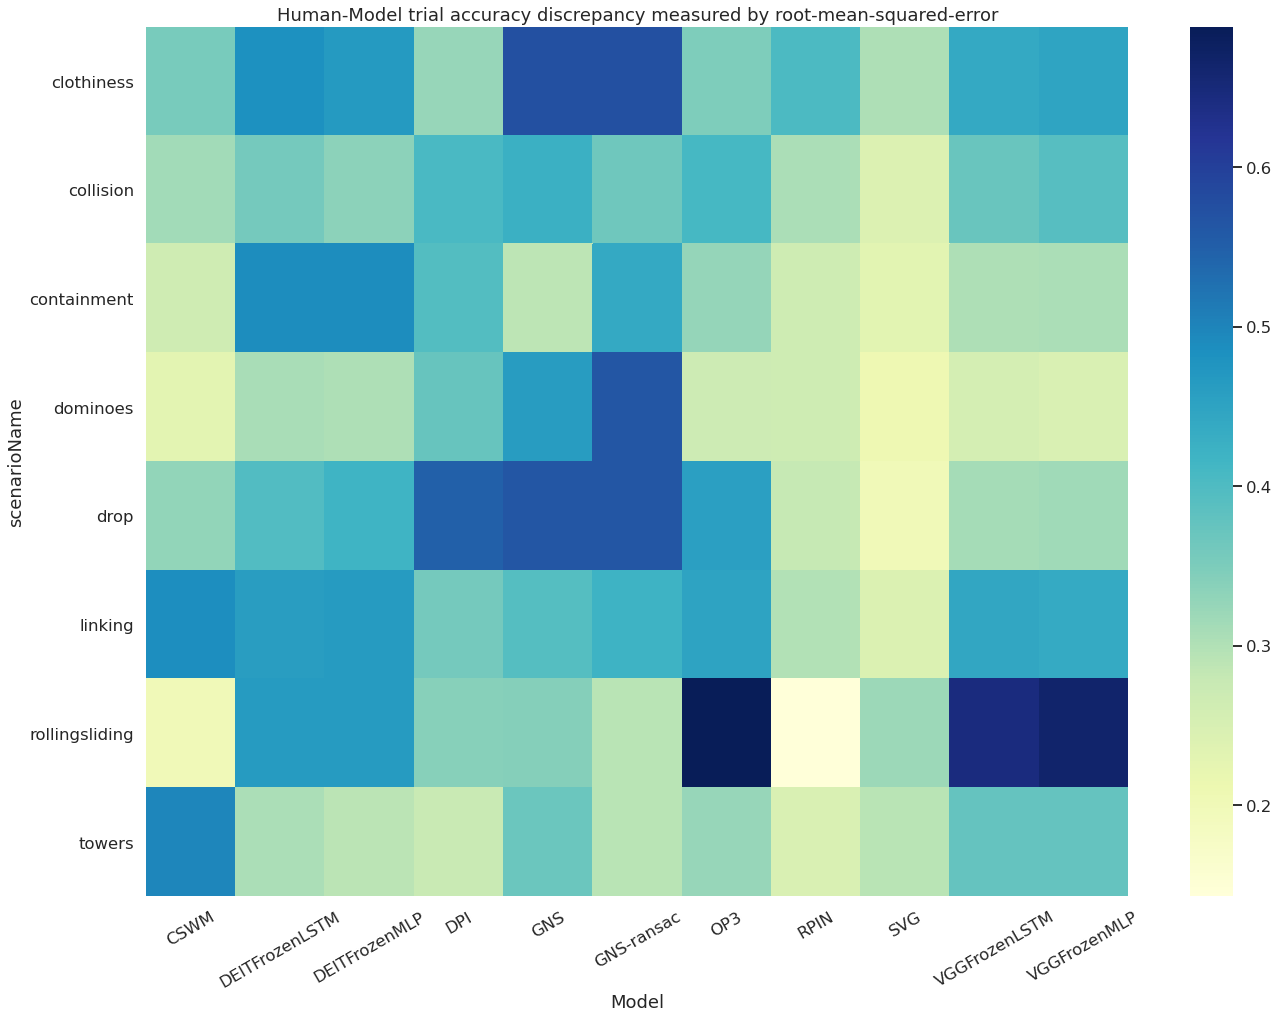

In [30]:
# plot the heat map
figure, ax = plt.subplots(figsize=(22,16)) 
ax = sns.heatmap(HM_disc, cmap="YlGnBu").set_title("Human-Model trial accuracy discrepancy measured by root-mean-squared-error")
plt.xticks(rotation=30)
plt.yticks(rotation=0)
plt.show()

## Step 3: Scatter plot that visualizes the relationship between full-dataset model-human correlations and the model-human agreement on the adversarial trials only

Take the model-human correlation values that we already report at the scenario level (8 scenarios x 11 models) in the Results and create a scatter plot that visualizes the relationship between these full-dataset model-human correlations and the model-human agreement on the adversarial trials only. 

In [31]:
# human-model adversarial trials
HM_disc_adv = MD_accu.merge(correct_below_50, how='inner', left_on=['Canon Stimulus Name','Readout Train Data'], right_on = ['stim_ID','scenarioName'], suffixes=('_model', '_human'))
HM_disc_adv['diff'] = HM_disc_adv['correct_model'] - HM_disc_adv['correct_human']
HM_disc_adv['root_sq'] = HM_disc_adv['diff']**2
HM_scenario = HM_disc_adv.groupby(['stim_ID','Model']).first()['scenarioName']
HM_disc_adv = HM_disc_adv.groupby(['stim_ID','Model']).agg({'root_sq':np.mean})

HM_disc_adv = HM_disc_adv.join(HM_scenario)
HM_disc_adv['rmse'] = np.sqrt(HM_disc_adv['root_sq'])
HM_disc_adv = HM_disc_adv.groupby(['scenarioName','Model']).agg({'rmse':np.mean})
HM_disc_adv['type'] = 'adv'
HM_disc_adv

rmse type
scenarioName Model                        
clothiness   CSWM            0.355235  adv
             DEITFrozenLSTM  0.482372  adv
             DEITFrozenMLP   0.468483  adv
             DPI             0.325962  adv
             GNS             0.574359  adv
...                               ...  ...
towers       OP3             0.325559  adv
             RPIN            0.247317  adv
             SVG             0.292170  adv
             VGGFrozenLSTM   0.376746  adv
             VGGFrozenMLP    0.376746  adv

[88 rows x 2 columns]

In [38]:
# human-model all trials
HM_disc_all = MD_accu.merge(correctness.reset_index(), how='inner', left_on=['Canon Stimulus Name','Readout Train Data'], right_on = ['stim_ID','scenarioName'], suffixes=('_model', '_human'))
HM_disc_all['diff'] = HM_disc_all['correct_model'] - HM_disc_all['correct_human']
HM_disc_all['root_sq'] = HM_disc_all['diff']**2
HM_scenario = HM_disc_all.groupby(['stim_ID','Model']).first()['scenarioName']
HM_disc_all = HM_disc_all.groupby(['stim_ID','Model']).agg({'root_sq':np.mean})

HM_disc_all = HM_disc_all.join(HM_scenario)
HM_disc_all['rmse'] = np.sqrt(HM_disc_all['root_sq'])
HM_disc_all = HM_disc_all.groupby(['scenarioName','Model']).agg({'rmse':np.mean})
HM_disc_all['type'] = 'all'
HM_disc_all

rmse type
scenarioName Model                        
clothiness   CSWM            0.274261  all
             DEITFrozenLSTM  0.401537  all
             DEITFrozenMLP   0.399725  all
             DPI             0.282946  all
             GNS             0.481225  all
...                               ...  ...
towers       OP3             0.399395  all
             RPIN            0.249101  all
             SVG             0.267336  all
             VGGFrozenLSTM   0.275984  all
             VGGFrozenMLP    0.278063  all

[88 rows x 2 columns]

In [39]:
HM_diff = HM_disc_all
HM_diff['diff_prop'] = (HM_disc_all['rmse'] - HM_disc_adv['rmse'])/HM_disc_all['rmse']

# get the rmse differece
HM_diff = HM_diff.drop(columns = ['type', 'rmse'])
HM_diff

diff_prop
scenarioName Model                    
clothiness   CSWM            -0.295242
             DEITFrozenLSTM  -0.201313
             DEITFrozenMLP   -0.172014
             DPI             -0.152027
             GNS             -0.193535
...                                ...
towers       OP3              0.184869
             RPIN             0.007162
             SVG             -0.092893
             VGGFrozenLSTM   -0.365102
             VGGFrozenMLP    -0.354894

[88 rows x 1 columns]

In [40]:
# create the pivot table
HM_diff = pd.pivot_table(HM_diff.reset_index(), index=['scenarioName'], columns=['Model'], values=['diff_prop'])
HM_diff.columns = HM_diff.columns.droplevel(0)
HM_diff

Model,CSWM,DEITFrozenLSTM,DEITFrozenMLP,DPI,GNS,GNS-ransac,OP3,RPIN,SVG,VGGFrozenLSTM,VGGFrozenMLP
scenarioName,,,,,,,,,,,
clothiness,-0.295242,-0.201313,-0.172014,-0.152027,-0.193535,-0.193364,0.034516,-0.250444,-0.227755,-0.118085,-0.127167
collision,0.122900,-0.110716,-0.042455,-1.478745,-1.457240,-1.026528,0.109877,-0.144974,0.120436,-0.196429,-0.272789
containment,0.242212,-0.414475,-0.409210,-0.545699,-0.156514,-0.585084,0.182119,-0.016935,0.191996,0.020915,0.014355
dominoes,0.365318,-0.110421,-0.086751,-0.684492,-0.202961,-0.352288,0.300490,-0.284342,0.201097,0.193328,0.220132
drop,0.000307,-0.103650,-0.153499,-0.842756,-0.573462,-0.562190,-0.035676,0.085610,0.305923,0.089814,0.074997
linking,-0.344086,-0.212016,-0.220842,-0.332188,-0.393529,-0.504908,-0.075248,-0.070198,-0.019156,-0.291388,-0.269329
rollingsliding,0.445508,-0.189767,-0.222639,-0.881940,-0.617133,-0.659641,-0.397413,0.474304,0.103503,-0.372678,-0.409406
towers,-0.777629,-0.065619,-0.020465,0.075774,-0.377917,-0.059886,0.184869,0.007162,-0.092893,-0.365102,-0.354894


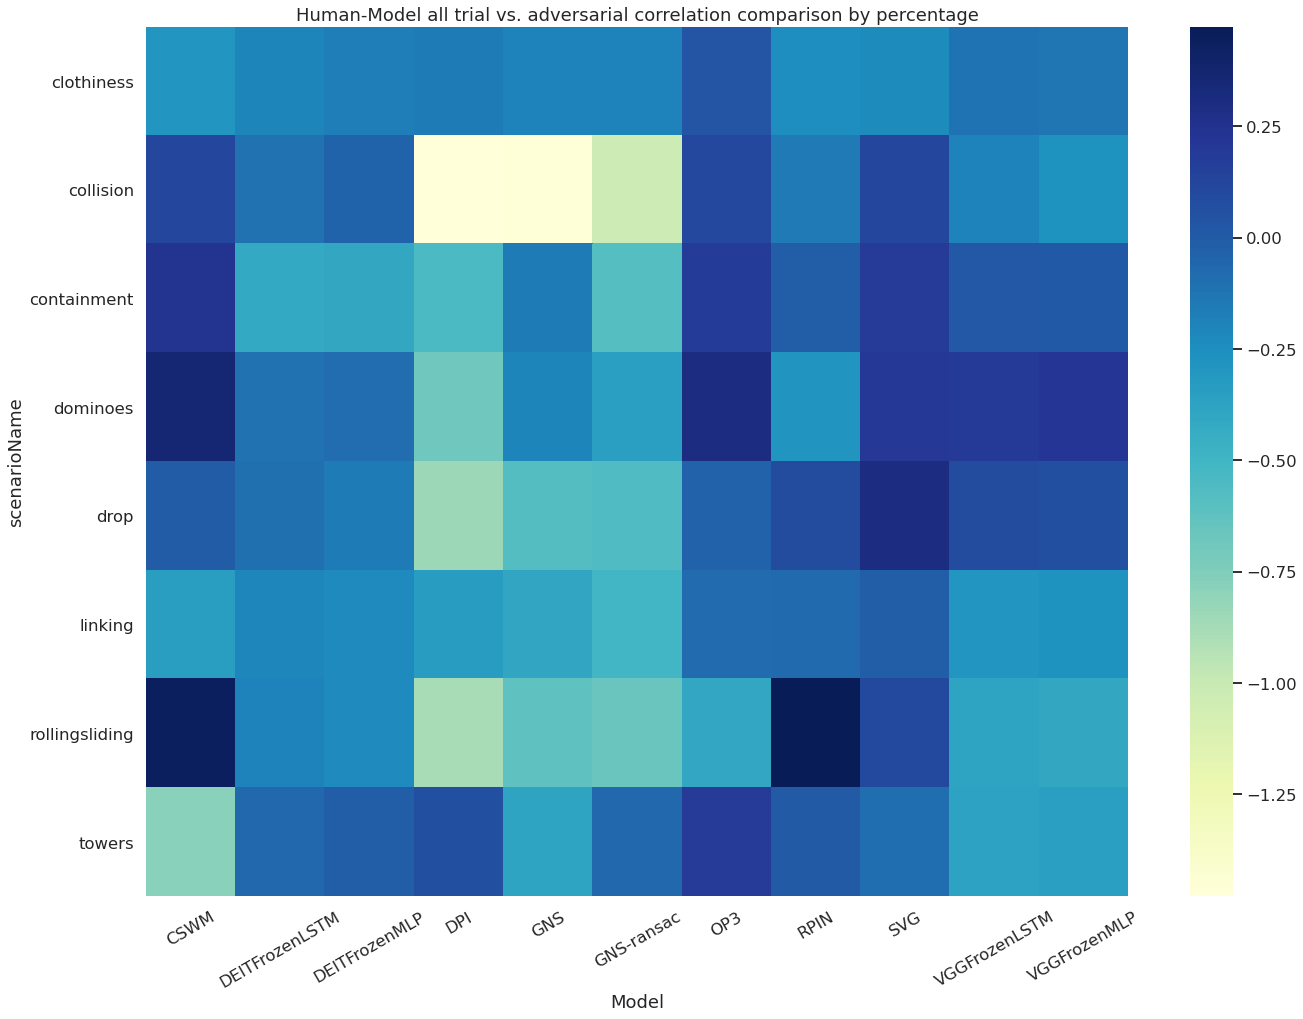

In [41]:
# plot the heat map
figure, ax = plt.subplots(figsize=(22,16)) 
ax = sns.heatmap(HM_diff, cmap="YlGnBu").set_title("Human-Model all trial vs. adversarial correlation comparison by percentage")
plt.xticks(rotation=30)
plt.yticks(rotation=0)
plt.show()

To the extent that models we say are behaving "like humans" are also getting the adversarial trials wrong, then that bolsters our claim that our original metric is providing us a reasonable proxy for model-human agreement overall. Insofar as some models that are behaving in a "human-like" way on the full dataset deviate strongly from human responses on the "adversarial" trials (they're getting them right, when humans are getting them wrong), then it suggests that these examples are providing us with useful additional granular signal about those cases where current models and humans systematically disagree, and suggest the importance of further exploring what is going on in such cases.

## Step 4: Overall proportion of below-chance human trials (by scenario)

We report the overall proportion of below-chance human trials in the Results, with the proportion broken out by scenario type.

In [35]:
# get the the total number of the trails in each scenario type
trial_total = HD.groupby(['scenarioName', 'stim_ID']).count().reset_index()
trial_total = trial_total.groupby('scenarioName').first()[['trialNum']]
trial_total

,trialNum
scenarioName,
clothiness,65
collision,94
containment,83
dominoes,84
drop,93
linking,86
rollingsliding,95
towers,85


In [36]:
# get the proportion of below-chance trials
correct_below_50_prop = correct_below_50_dist['stim_ID']/trial_total['trialNum']
correct_below_50_prop = correct_below_50_prop.to_frame().rename(columns={0: "prop"})
correct_below_50_prop

,prop
scenarioName,
clothiness,0.246154
collision,0.170213
containment,0.216867
dominoes,0.333333
drop,0.258065
linking,0.395349
rollingsliding,0.052632
towers,0.223529
